In [36]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn import ensemble

import os

%matplotlib inline

In [2]:
TRAIN = pd.read_csv("train.csv")

In [3]:
KAGGLE_TEST = pd.read_csv("test.csv")

In [4]:
TRAIN.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [5]:
KAGGLE_TEST.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
weather_dummies = pd.get_dummies(TRAIN['weather'], prefix='weather')
weather_dummies.head()
season_dummies = pd.get_dummies(TRAIN['season'], prefix='season')
season_dummies.head()
x = pd.concat([weather_dummies, season_dummies], axis=1)
x.head()


,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,1,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0


In [7]:
# Feature Engineering/Extraction
def feature_extraction(df):
    # Copy the DataFrame (TODO)
    dataframe = df.copy(deep=True)
    '''Engineer Features from Data'''
    '''Break Date Time into multiple features: year, month, day, hour etc'''
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours 
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter
    
    # Weather
    #weather_dummies = pd.get_dummies(dataframe['weather'], prefix='weather')
    #dataframe = pd.concat([dataframe, weather_dummies], axis=1)      

    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)
    
    # Season
    #season_dummies = pd.get_dummies(dataframe['season'], prefix='season')
    #dataframe = pd.concat([dataframe, season_dummies], axis=1)  
    
    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)
    
    # Sunday (Least Bikes Rented on Sundays)
    dataframe['sunday'] = dataframe['day'].map(lambda x: 1 if x == 6 else 0)
    
    # Bucket Hours of Day
    #labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']
    #lens['age_group'] = pd.cut(dataframe.hour, range(0, 23, 6), right=False, labels=labels)
    dataframe['hour_0_3'] = dataframe['hour'].map(lambda x: 1 if 0 <= x <= 3 else 0)
    dataframe['hour_4_7'] = dataframe['hour'].map(lambda x: 1 if 4 <= x <= 7 else 0)
    dataframe['hour_8_11'] = dataframe['hour'].map(lambda x: 1 if 8 <= x <= 11 else 0)
    dataframe['hour_12_15'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 15 else 0)
    dataframe['hour_16_19'] = dataframe['hour'].map(lambda x: 1 if 16 <= x <= 19 else 0)
    dataframe['hour_20_23'] = dataframe['hour'].map(lambda x: 1 if 20 <= x <= 23 else 0)
    
    return dataframe

In [29]:
def feature_selection(training, kaggle_test=KAGGLE_TEST):
    '''Select Features from Data'''    
    '''
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
                'year', 'month', 'hour', 'day', 'dayofyear', 'week', 'quarter', 
                'weather1', 'weather2', 'weather3', 'weather4', 
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']
    '''
    
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
                'year', 'month', 'day', 'dayofyear', 'week', 
                'weather1', 'weather2', 'weather3', 'weather4', 
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']
    
    # Kaggle
    kaggle_test_set = kaggle_test[features]
    # Training Set
    features.insert(0, 'count')
    training_set = training[features]
    
    return (training_set, kaggle_test_set)

In [30]:
TRAIN_FX = feature_extraction(TRAIN)
TRAIN_FX.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,dayofyear,week,quarter,weather1,weather2,weather3,weather4,season1,season2,season3,season4,sunday,hour_0_3,hour_4_7,hour_8_11,hour_12_15,hour_16_19,hour_20_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0,5,1,52,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5,1,52,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2,5,1,52,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3,5,1,52,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4,5,1,52,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 05:00:00,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,5,5,1,52,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 06:00:00,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,6,5,1,52,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 07:00:00,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,7,5,1,52,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 08:00:00,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,8,5,1,52,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [31]:
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)
KAGGLE_TEST_FX.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,day,dayofyear,week,quarter,weather1,weather2,weather3,weather4,season1,season2,season3,season4,sunday,hour_0_3,hour_4_7,hour_8_11,hour_12_15,hour_16_19,hour_20_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,20,3,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-20 01:00:00,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,20,3,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-20 02:00:00,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,20,3,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-20 03:00:00,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3,20,3,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2011-01-20 04:00:00,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3,20,3,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [11]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
TRAIN_FX.describe()

height has been deprecated.



,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,dayofyear,week,quarter,weather1,weather2,weather3,weather4,season1,season2,season3,season4,sunday,hour_0_3,hour_4_7,hour_8_11,hour_12_15,hour_16_19,hour_20_23
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,11.541613,3.013963,177.562466,25.917784,2.506614,0.660665,0.260334,0.078909,0.000092,0.246739,0.251056,0.251056,0.251148,0.145049,0.164431,0.165717,0.167187,0.167555,0.167555,0.167555
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,6.915838,2.004585,105.055551,15.017269,1.116174,0.473505,0.438837,0.269609,0.009584,0.431133,0.433641,0.433641,0.433694,0.352166,0.370684,0.371844,0.373160,0.373487,0.373487,0.373487
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,6.000000,1.000000,92.000000,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,12.000000,3.000000,182.500000,26.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,18.000000,5.000000,274.000000,40.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,23.000000,6.000000,354.000000,52.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
'''
features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
                'year', 'month', 'hour', 'day', 'dayofyear', 'week', 'quarter', 
                'weather1', 'weather2', 'weather3', 'weather4', 
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']
'''
features = ['count', 'season', 'workingday', 'temp', 'atemp', 'windspeed', 
                'year', 'month', 'hour', 'dayofyear', 'week', 'quarter', 
                'weather1', 
                'season2', 'season3', 'season4', 
                'sunday',
                'hour_8_11', 'hour_12_15', 'hour_16_19']

TRAIN_FX[features].corr()

,count,season,workingday,temp,atemp,windspeed,year,month,hour,dayofyear,week,quarter,weather1,season2,season3,season4,sunday,hour_8_11,hour_12_15,hour_16_19
count,1.000000,0.163439,0.011594,0.394454,0.389784,0.101369,0.260403,0.166862,0.400601,0.168056,0.152512,0.163439,0.105246,0.075681,0.136942,0.023704,-0.024409,0.126164,0.152164,0.473680
season,0.163439,1.000000,-0.008126,0.258689,0.264744,-0.147121,-0.004797,0.971524,-0.006546,0.970196,0.939284,1.000000,-0.011919,-0.262801,0.255939,0.774867,-0.000688,-0.001332,-0.002659,-0.002659
workingday,0.011594,-0.008126,1.000000,0.029966,0.024660,0.013373,-0.002482,-0.003394,0.002780,-0.003024,-0.022593,-0.008126,-0.024078,0.014620,-0.007194,-0.007048,-0.601643,0.000427,0.001100,0.001100
temp,0.394454,0.258689,0.029966,1.000000,0.984948,-0.017852,0.061226,0.257589,0.145430,0.255887,0.240794,0.258689,0.058430,0.192661,0.635975,-0.266220,-0.009986,-0.021859,0.146797,0.119797
atemp,0.389784,0.264744,0.024660,0.984948,1.000000,-0.057473,0.058540,0.264173,0.140343,0.262245,0.248653,0.264744,0.055825,0.204421,0.607090,-0.245690,-0.004147,-0.021940,0.141321,0.112408
windspeed,0.101369,-0.147121,0.013373,-0.017852,-0.057473,1.000000,-0.015221,-0.150192,0.146631,-0.148062,-0.145962,-0.147121,0.015920,0.042991,-0.091521,-0.079535,-0.015138,0.016635,0.140525,0.141427
year,0.260403,-0.004797,-0.002482,0.061226,0.058540,-0.015221,1.000000,-0.004932,-0.004234,-0.000837,-0.003411,-0.004797,-0.000339,-0.002446,-0.001598,-0.002234,0.011715,-0.000744,-0.001731,-0.001731
month,0.166862,0.971524,-0.003394,0.257589,0.264173,-0.150192,-0.004932,1.000000,-0.006818,0.998616,0.961809,0.971524,-0.017101,-0.255581,0.248354,0.753087,-0.001018,-0.001224,-0.002800,-0.002800
hour,0.400601,-0.006546,0.002780,0.145430,0.140343,0.146631,-0.004234,-0.006818,1.000000,-0.006735,-0.006532,-0.006546,0.038791,-0.002733,-0.002611,-0.002964,-0.001026,-0.132275,0.127050,0.386549
dayofyear,0.168056,0.970196,-0.003024,0.255887,0.262245,-0.148062,-0.000837,0.998616,-0.006735,1.000000,0.961538,0.970196,-0.017194,-0.257348,0.247492,0.753112,-0.001413,-0.001265,-0.002758,-0.002758


In [13]:
TRAIN_FX[['hour','count']].groupby('hour', sort=True).sum()

,count
hour,
0,25088
1,15372
2,10259
3,5091
4,2832
5,8935
6,34698
7,96968
8,165060


In [14]:
TRAIN_FX[['dayofyear', 'year', 'count']].groupby(['dayofyear', 'year']).sum().sort('count', ascending=False)[:10]

,,count
dayofyear,year,
259,2012,8714
140,2012,8294
253,2012,8227
279,2012,8156
154,2012,8120
258,2012,8009
280,2012,7965
256,2012,7870
231,2012,7865


In [15]:
TRAIN_FX[['week','count']].groupby('week').sum().sort('count', ascending=False)[:10]

,count
week,
37,86487
28,82601
24,82330
23,82089
40,79470
32,79110
41,77072
27,76436
19,74145


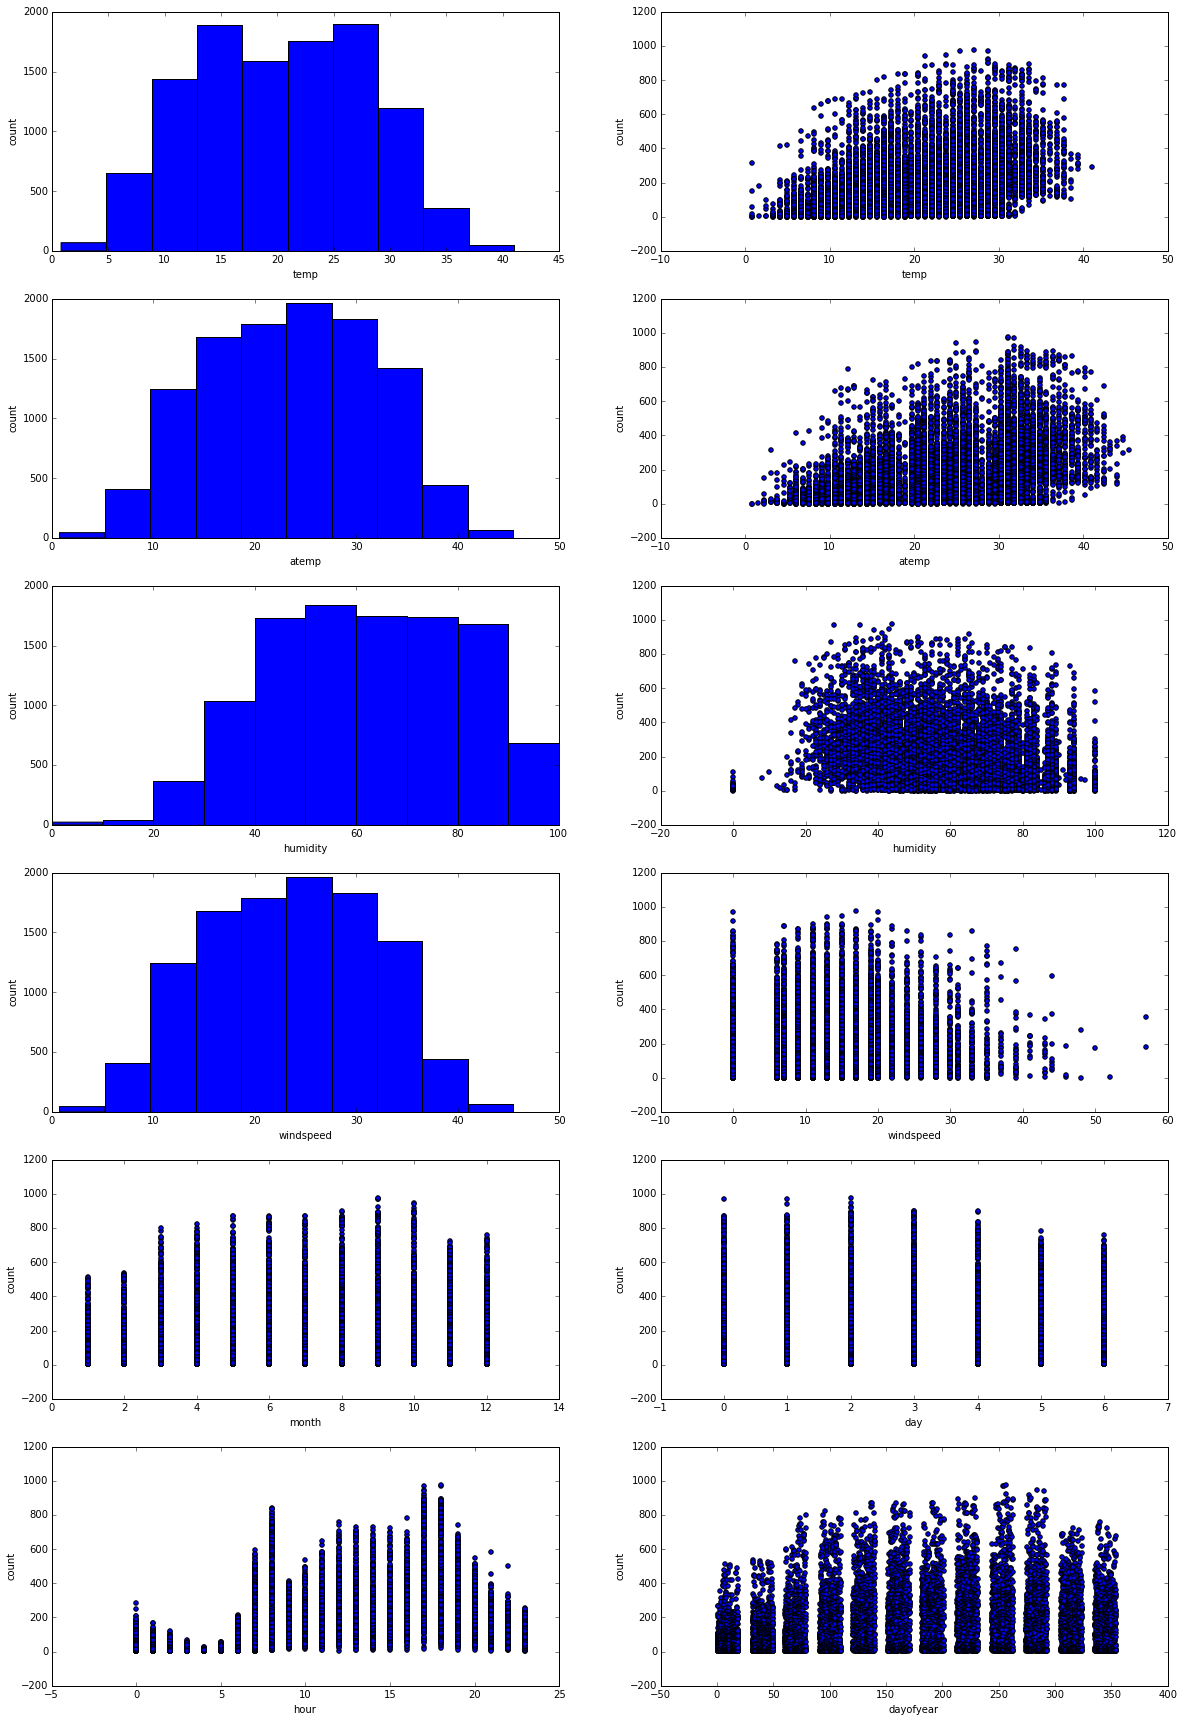

In [16]:
# Exploratory Data Analysis
fig = plt.figure(figsize=(20, 30), dpi=80)
ax1 = fig.add_subplot(621)
ax1.set_xlabel("temp")
ax1.set_ylabel("count")
ax1.hist(TRAIN_FX.temp)
ax2 = fig.add_subplot(622)
ax2.set_xlabel("temp")
ax2.set_ylabel("count")
ax2.scatter(TRAIN_FX['temp'], TRAIN_FX['count'])

ax1 = fig.add_subplot(623)
ax1.set_xlabel("atemp")
ax1.set_ylabel("count")
ax1.hist(TRAIN_FX.atemp)
ax2 = fig.add_subplot(624)
ax2.set_xlabel("atemp")
ax2.set_ylabel("count")
ax2.scatter(TRAIN_FX['atemp'], TRAIN_FX['count'])

ax1 = fig.add_subplot(625)
ax1.set_xlabel("humidity")
ax1.set_ylabel("count")
ax1.hist(TRAIN_FX.humidity)
ax2 = fig.add_subplot(626)
ax2.set_xlabel("humidity")
ax2.set_ylabel("count")
ax2.scatter(TRAIN_FX['humidity'], TRAIN_FX['count'])

ax1 = fig.add_subplot(627)
ax1.set_xlabel("windspeed")
ax1.set_ylabel("count")
ax1.hist(TRAIN_FX.atemp)
ax2 = fig.add_subplot(628)
ax2.set_xlabel("windspeed")
ax2.set_ylabel("count")
ax2.scatter(TRAIN_FX['windspeed'], TRAIN_FX['count'])

ax1 = fig.add_subplot(629)
ax1.set_xlabel("month")
ax1.set_ylabel("count")
ax1.scatter(TRAIN_FX['month'], TRAIN_FX['count'])

ax1 = fig.add_subplot(6,2,10)
ax1.set_xlabel("day")
ax1.set_ylabel("count")
ax1.scatter(TRAIN_FX['day'], TRAIN_FX['count'])

ax1 = fig.add_subplot(6,2,11)
ax1.set_xlabel("hour")
ax1.set_ylabel("count")
ax1.scatter(TRAIN_FX['hour'], TRAIN_FX['count'])

ax1 = fig.add_subplot(6,2,12)
ax1.set_xlabel("dayofyear")
ax1.set_ylabel("count")
ax1.scatter(TRAIN_FX['dayofyear'], TRAIN_FX['count'])



In [38]:
def output_model_summary(estimator, dev_data, dev_labels, test_data=None, test_labels=None):
    '''Prints Model Summary'''
    
    # The coefficients
    if 'coef_' in dir(estimator):
        print('Coefficients: \n', estimator.coef_)
    
    if 'intercept_' in dir(estimator):
        print('Intercept: \n', estimator.intercept_)
    
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((np.rint(estimator.predict(dev_data)) - dev_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('[DEV] R^2 - Variance score: %.2f' % estimator.score(dev_data, dev_labels))
    if test_data and test_labels:
        print('[TEST] R^2 - Variance score: %.2f' % estimator.score(test_data, test_labels))

In [40]:
# Kaggle Baseline
def generate_kaggle_submission(pred, f_name):
    print "\n\n Generating Kaggle Submission File: %s" % (f_name)
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    print pred
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])
    
    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)
    
    print df_dt.head()
    print df_pred.head()
    
    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print output.head()
    
    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

In [32]:
# Feature Selection & Scaling
TRAIN_FX_FS, KAGGLE_TEST_FX_FS  = feature_selection(TRAIN_FX, KAGGLE_TEST_FX)
Y = TRAIN_FX_FS['count'].values
X = TRAIN_FX_FS.drop('count', axis=1).values
X1 = KAGGLE_TEST_FX_FS.values
print "### Shape of training set (X)", X.shape
print "### Shape of labels (Y)", Y.shape
print "### Shape of Kaggle Test set (X1)", X1.shape

# Scale features
scaler = preprocessing.StandardScaler()
X_SCALED = scaler.fit_transform(X)
X1_SCALED = scaler.transform(X1)
print "### (After scaling) Shape of training set", X_SCALED.shape
print "### (After scaling ) Shape of Kaggle Test set", X1_SCALED.shape

# Find Important Features using Random Forest
xtClf = ExtraTreesClassifier().fit(X_SCALED, Y)
X_SCALED_SUBSET = xtClf.transform(X_SCALED)
X1_SCALED_SUBSET = xtClf.transform(X1_SCALED)
importances = xtClf.feature_importances_
print xtClf.feature_importances_
print "### (After scaling & feature selection using Random Forrest) Shape of training set", X_SCALED_SUBSET.shape
print "### (After scaling & feature selection using Random Forrest) Shape of Kaggle Test set", X1_SCALED_SUBSET.shape

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in xrange(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

### Shape of training set (X) (10886, 28)
### Shape of labels (Y) (10886,)
### Shape of Kaggle Test set (X1) (6493, 28)
### (After scaling) Shape of training set (10886, 28)
### (After scaling ) Shape of Kaggle Test set (6493, 28)
[  4.11080998e-03   3.25044432e-03   9.90441758e-03   1.13894044e-02
   1.36199329e-01   1.37328487e-01   1.70309323e-01   2.25401570e-01
   1.50284476e-02   2.67673768e-02   5.92618158e-02   8.32022287e-02
   5.96748262e-02   9.70544361e-03   1.05963651e-02   5.54022972e-03
   3.93891352e-05   1.45691679e-03   2.64793212e-03   3.20819359e-03
   2.06208937e-03   7.86604851e-03   2.89848571e-03   2.79163489e-03
   2.69106003e-03   2.88686202e-03   1.79189062e-03   1.98897853e-03]
### (After scaling & feature selection using Random Forrest) Shape of training set (10886, 7)
### (After scaling & feature selection using Random Forrest) Shape of Kaggle Test set (6493, 7)
Feature ranking:
1. feature 7 (0.225402)
2. feature 6 (0.170309)
3. feature 5 (0.137328)
4. fea

In [33]:
#  OLS with Cross Validation
ols = linear_model.LinearRegression()
ss = cross_validation.ShuffleSplit(X.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    ols.fit(X[train_index], Y[train_index])

    # Model Summary
    output_model_summary(ols, X[test_index], Y[test_index])
    
    count += 1

# Train the model using the entire data set
ols.fit(X, Y)
pred = ols.predict(X1)
generate_kaggle_submission(pred, "ols.csv")


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([  -0.23760639,   -7.6810995 ,   -1.67681956,  -38.35761998,
          3.11345163,    1.89610826,   -0.60198305,   -0.59902455,
         86.49559988,   -6.3495566 ,    2.17370131,    0.48599775,
         -0.36538224,   -2.86375255,   21.98314809,    2.98258146,
        -22.10197699,   -9.92464411,   19.4648375 ,   -8.91813629,
         -0.62205711,  -25.238064  , -149.65044885,  -93.30017463,
         54.31110221,   44.01910188,  177.57562445,  -32.95520505]))
('Intercept: \n', -173844.357690768)
Residual sum of squares: 13311.04
[DEV] R^2 - Variance score: 0.59

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([  -2.56711252,   -4.21688479,    1.6198265 ,  -38.36173045,
          2.62348328,    2.22290569,   -0.60091742,   -0.6700121 ,
         88.3730083 ,   -7.8088957 ,    2.99320295,    0.58708974,
         -0.59842547,   -4.96022049,   22.164585  ,    8.91322194,

In [41]:
#  Random Forrest with Cross Validation
rf = ensemble.RandomForestRegressor(n_estimators=500)
ss = cross_validation.ShuffleSplit(X.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    rf.fit(X[train_index], Y[train_index])

    # Model Summary
    output_model_summary(rf, X[test_index], Y[test_index])
    
    count += 1

# Train the model using the entire data set
rf.fit(X, Y)
pred = rf.predict(X1)
generate_kaggle_submission(pred, "rf.csv")


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares: 10174.10
[DEV] R^2 - Variance score: 0.69

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares: 9727.28
[DEV] R^2 - Variance score: 0.70

 [Iteration:3] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares: 10069.37
[DEV] R^2 - Variance score: 0.70

 [Iteration:4] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares: 9594.56
[DEV] R^2 - Variance score: 0.71

 [Iteration:5] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares: 10024.14
[DEV] R^2 - Variance score: 0.70


 Generating Kaggle Submission File: rf.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
[  10.1      8.2      8.2   ...,   91.325  126.825   95.425]
              datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
   count
0     10
1      8
2      8
3      5
4    

In [34]:
#  Lasso with Cross Validation
alpha = 0.1
lasso = linear_model.Lasso(alpha=alpha)
ss = cross_validation.ShuffleSplit(X_SCALED_SUBSET.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    lasso.fit(X_SCALED_SUBSET[train_index], Y[train_index])

    # Model Summary
    output_model_summary(lasso, X_SCALED_SUBSET[test_index], Y[test_index])
    
    count += 1

# Train the model using the entire data set
lasso.fit(X_SCALED_SUBSET, Y)
pred = lasso.predict(X1_SCALED_SUBSET)
generate_kaggle_submission(pred, "lasso.csv")


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([ 23.69791815,  37.06745329, -57.8424551 ,   5.77714779,
        -0.93397099,  28.52064727,  -0.        ]))
('Intercept: \n', 191.45403365525044)
Residual sum of squares: 24022.21
[DEV] R^2 - Variance score: 0.27

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([ 20.6030584 ,  40.44532261, -57.70444304,   5.44389943,
        -0.3966398 ,  27.1156108 ,  -0.19454016]))
('Intercept: \n', 192.07438913773808)
Residual sum of squares: 22741.30
[DEV] R^2 - Variance score: 0.29

 [Iteration:3] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([  9.58514014,  51.26805415, -59.24427764,   5.02343136,
         1.18373112,  26.9417496 ,  -0.34531436]))
('Intercept: \n', 190.66064505686575)
Residual sum of squares: 24899.59
[DEV] R^2 - Variance score: 0.26

 [Iteration:4] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([ 13.51642562,  48.86

In [35]:
#  Elastic Net with Cross Validation
alpha = 0.1
enet = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.5)
ss = cross_validation.ShuffleSplit(X_SCALED.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    enet.fit(X_SCALED[train_index], Y[train_index])

    # Model Summary
    output_model_summary(enet, X_SCALED[test_index], Y[test_index])
    
    count += 1

# Train the model using the entire data set
enet.fit(X_SCALED, Y)
pred = enet.predict(X1_SCALED)
generate_kaggle_submission(pred, "enet.csv")


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([  1.80802957,  -1.25295412,  -0.4275119 ,  -6.82989568,
        20.84632706,  19.20908194, -13.42332607,  -3.79645632,
        41.16617479,   8.38243137,   3.63100057,  10.57242619,
         0.30223552,   2.86780877,   1.91976549, -10.49111078,
        -0.74226017,  -5.80911229,   7.58392212,  -2.92911632,
         1.14619742,  -7.80602312, -53.02161993, -32.96627292,
        19.25183492,  15.05635847,  63.04443252, -11.90293743]))
('Intercept: \n', 191.30399118313588)
Residual sum of squares: 13340.73
[DEV] R^2 - Variance score: 0.59

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
('Coefficients: \n', array([  0.9391137 ,  -1.05570642,   0.4109321 ,  -6.03870174,
        19.730076  ,  19.42682078, -13.33566917,  -4.41378508,
        42.13184369,   9.12320012,   4.78164438,  11.798704  ,
        -0.71095147,   2.36526689,   1.8621868 ,  -9.50695472,
        -0.80717773,  -5.64842916,   8.863

In [49]:
# Elastic Net CV
# Hyperparameters
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
li_ratios = [.1, .5, .7, .9, .95, .99, 1]

enetCV = linear_model.ElasticNetCV(alphas=alphas, l1_ratio=li_ratios, cv=10)

# Train the model using the training sets
enetCV.fit(X_SCALED, Y)

print 'alpha: %s' % enetCV.alpha_
print 'l1_ratio: %s' % enetCV.l1_ratio_


# Model Summary
output_model_summary(enetCV, X_SCALED, Y)

# Train the model using the entire data set
pred = enetCV.predict(X1_SCALED)
generate_kaggle_submission(pred, "enetCV.csv")

alpha: 0.5
l1_ratio: 0.9
('Coefficients: \n', array([  0.        ,  -0.38363774,  -0.        ,  -0.        ,
        30.95206303,  28.50104   , -35.54051768,   4.68143825,
        38.58153815,   9.60301249,  51.02439065,   3.6692961 ,
        11.33477422,   0.46373361,   0.        ,  -0.        ,
         2.06141479,  -7.82823301,   0.12655334,  -0.12456764,
         4.29546543, -10.08885227,   5.85139812,  -4.98038688]))
('Intercept: \n', 191.57413191254034)
Residual sum of squares: 19781.57
[DEV] R^2 - Variance score: 0.40


 Generating Kaggle Submission File: enetCV.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
[ -21.10972531  -21.11675207  -13.73474444 ...,  262.85151427  278.91594306
  269.71769822]
              datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
   count
0      0
1      0
2      0
3      0
4      5
Shape of Submission Dataframe:  (6493, 2)
           

/Users/ssatpati/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [50]:
# Correlation Matrix
TRAIN_FX_FS.corr()

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,day,dayofyear,week,quarter,weather1,weather2,weather3,weather4,season1,season2,season3,season4,sunday
count,1.000000,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,0.260403,0.166862,0.400601,-0.002283,0.168056,0.152512,0.163439,0.105246,-0.041329,-0.117519,-0.001459,-0.237704,0.075681,0.136942,0.023704,-0.024409
season,0.163439,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,-0.004797,0.971524,-0.006546,-0.010553,0.970196,0.939284,1.000000,-0.011919,0.012614,0.000860,-0.012938,-0.772567,-0.262801,0.255939,0.774867,-0.000688
holiday,-0.005393,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.012021,0.001731,-0.000354,-0.191832,0.001134,0.000976,0.029368,-0.001708,0.013868,-0.019514,-0.001644,-0.007336,-0.038250,0.022790,0.022751,-0.070636
workingday,0.011594,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.002482,-0.003394,0.002780,-0.704267,-0.003024,-0.022593,-0.008126,-0.024078,0.003324,0.036643,0.006562,-0.000379,0.014620,-0.007194,-0.007048,-0.601643
weather,-0.128655,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.012548,0.012144,-0.022740,-0.047692,0.011746,0.019762,0.008879,-0.921166,0.544369,0.730368,0.039040,0.005414,0.004157,-0.047316,0.037771,-0.025393
temp,0.394454,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.061226,0.257589,0.145430,-0.038466,0.255887,0.240794,0.258689,0.058430,-0.046925,-0.025715,-0.014800,-0.565655,0.192661,0.635975,-0.266220,-0.009986
atemp,0.389784,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.058540,0.264173,0.140343,-0.040235,0.262245,0.248653,0.264744,0.055825,-0.040792,-0.031154,-0.013901,-0.569082,0.204421,0.607090,-0.245690,-0.004147
humidity,-0.317371,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.078606,0.204537,-0.278011,-0.026507,0.203155,0.216435,0.190610,-0.374837,0.222398,0.295894,0.012010,-0.166208,-0.031095,0.067308,0.129018,0.027087
windspeed,0.101369,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,-0.015221,-0.150192,0.146631,-0.024804,-0.148062,-0.145962,-0.147121,0.015920,-0.045016,0.045597,-0.007979,0.128819,0.042991,-0.091521,-0.079535,-0.015138
year,0.260403,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,1.000000,-0.004932,-0.004234,-0.003785,-0.000837,-0.003411,-0.004797,-0.000339,0.019064,-0.030774,0.009548,0.006315,-0.002446,-0.001598,-0.002234,0.011715


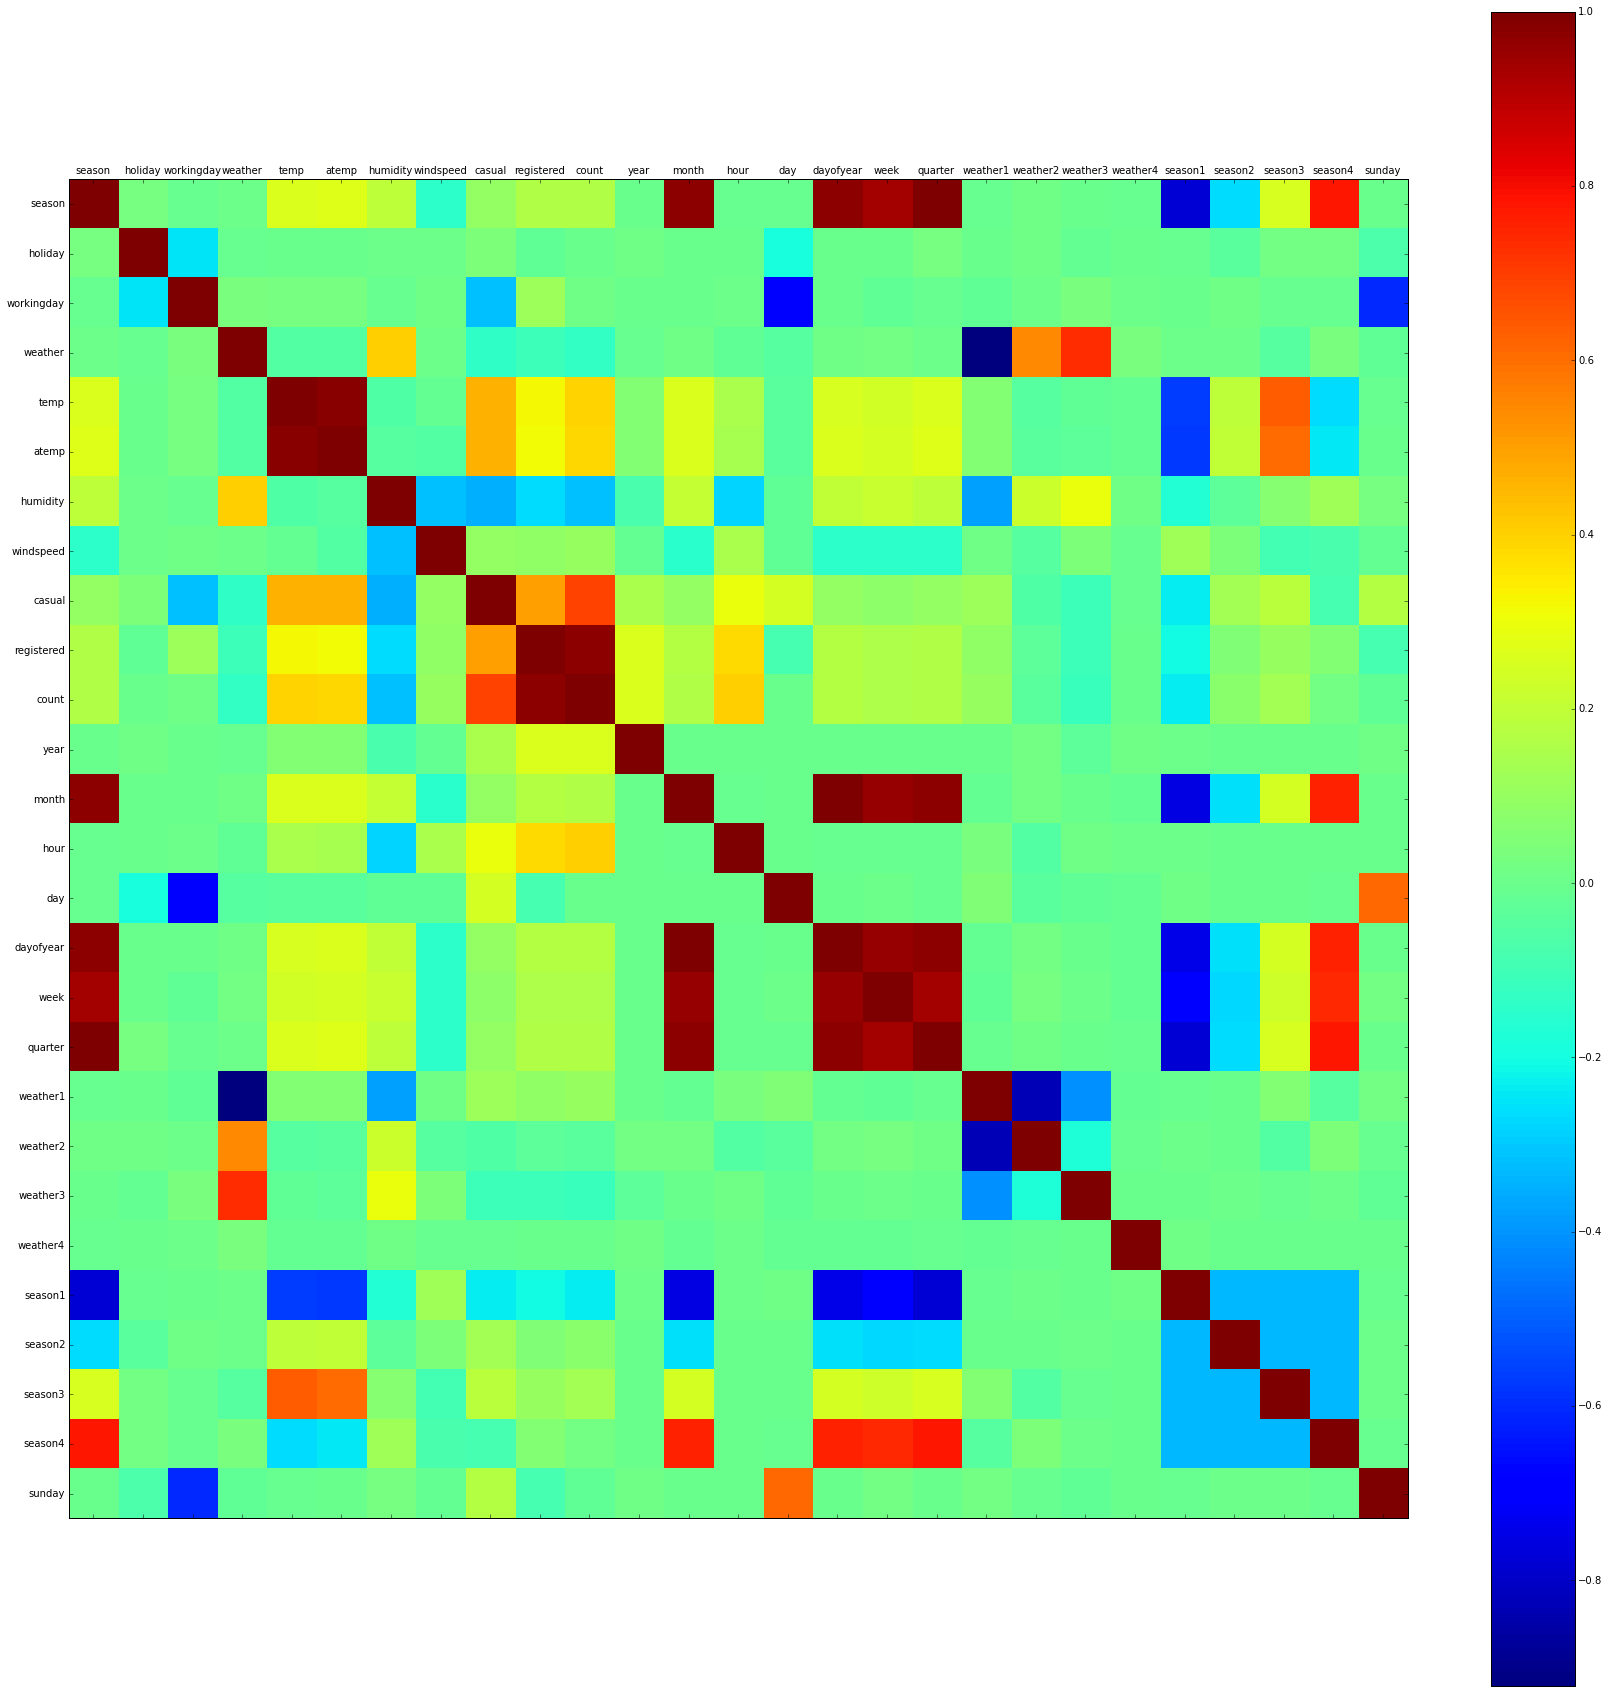

In [52]:
def plot_corr(TRAIN_FX_FS,size=30):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
plot_corr(df)

In [ ]:
#scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [ ]:
# Feature Selection
X, Y = feature_selection(df)
print "Shape of all features: ", X.shape
print "Shape of labels: ", Y.shape
KAGGLE_TEST_DATA = feature_selection(KAGGLE_TEST_DATA)
print "Shape of KAGGLE TEST SET: ", KAGGLE_TEST_DATA.shape

In [ ]:
test_data, test_labels = X[9000:], Y[9000:]
dev_data, dev_labels = X[7000:9000], Y[7000:9000]
train_data, train_labels = X[:7000], Y[:7000]
print 'train data shape: ', train_data.shape
print 'train label shape:', train_labels.shape
print 'dev data shape: ', dev_data.shape
print 'dev label shape:', dev_labels.shape
print 'test data shape: ', test_data.shape
print 'test labels shape:', test_labels.shape

In [ ]:
# Commenting out Feature Scaling at this point
#scaler = preprocessing.StandardScaler().fit(train_data)
#test_data_scaled = scaler.transform(test_data)
#dev_data_scaled = scaler.transform(dev_data) 
#train_data_scaled = scaler.transform(train_data) 

In [31]:
def output_model_summary(estimator, dev, test=None):
    '''Prints Model Summary'''
    # The coefficients
    if 'coef_' in dir(estimator):
        print('Coefficients: \n', estimator.coef_)
    print('Intercept: \n', estimator.intercept_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((np.rint(estimator.predict(dev)) - dev_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('[DEV] R^2 - Variance score: %.2f' % estimator.score(dev, dev_labels))
    if test:
        print('[TEST] R^2 - Variance score: %.2f' % estimator.score(test, test_labels))

In [ ]:
# Ordinary Least Squares (Baseline)
# Create linear regression object
ols = linear_model.LinearRegression()

# Train the model using the training sets
ols.fit(train_data, train_labels)

# Model Summary
output_model_summary(ols, dev_data, test_data)

In [ ]:
# Kaggle Baseline
def generate_kaggle_submission(pred, f_name):
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST_DATA.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])
    
    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)
    
    print df_dt.head()
    print df_pred.head()
    
    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print output.head()
    
    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

In [ ]:
# Generate Kaggle Baseline
# Train the model using the entire data set
ols.fit(X, Y)
pred = ols.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "baseline.csv")

In [ ]:
# Ridge Regression
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])

# Train the model using the training sets
clf.fit(train_data, train_labels)

# Model Summary
output_model_summary(clf, dev_data, test_data)

# Kaggle Submission with SVR Linear
clf.fit(X, Y)
pred = clf.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "submission_ridge.csv")

In [ ]:
svr = svm.SVR(kernel='linear')

# Train the model using the training sets
svr.fit(train_data, np.squeeze(train_labels))

# Model Summary

output_model_summary(svr, dev_data, test_data)

# Kaggle Submission with SVR Linear
pred = svr.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "submission_svr_linear.csv")

In [ ]:
# Polynomial Features
poly = preprocessing.PolynomialFeatures(2)
test_data_poly = poly.fit_transform(test_data)
dev_data_poly = poly.transform(dev_data) 
train_data_poly = poly.transform(train_data) 
print 'train data shape: ', train_data_poly.shape
print 'dev data shape: ', dev_data_poly.shape
print 'test data shape: ', test_data_poly.shape


# Train the model using the training sets
clf.fit(train_data_poly, train_labels)

# Model Summary
output_model_summary(clf, dev_data_poly, test_data_poly)

# Kaggle Submission with Poly Ridge
kaggle_test_poly = poly.transform(KAGGLE_TEST_DATA) 
print 'Kaggle Test Poly Shape: ', kaggle_test_poly.shape
pred = clf.predict(kaggle_test_poly)
generate_kaggle_submission(pred, "submission_poly_ridge.csv")